In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(100)

# (함수) DataFrame으로 불러오는 함수

In [2]:
import pandas as pd

In [3]:
def openDataFrame(path):
    return pd.read_csv(path, on_bad_lines='skip', encoding = "ISO-8859-1")

# 3.26 Wine Quality Prediction Analysis - Classification

In [4]:
path_wine = './winequality.csv'

In [5]:
df_wine = openDataFrame(path_wine)
df_wine

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


# 1. 전처리기(나만의 변환기들)

In [6]:
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

## 1.1 변환기: Type 이진화

In [7]:
class TypeBinaryConverter(BaseEstimator, TransformerMixin):
    def __init__(self, name='type'):
        self.name = name
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[self.name] = (X[self.name] == 'white').astype(int)
        return X

## 1.2 변환기: quality 3->4, 9->8 변환

In [8]:
class MergeQuality(BaseEstimator, TransformerMixin):
    def __init__(self, name='quality'):
        self.name = name
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X[self.name] = X[self.name].replace({3:4, 9:8})
        return X

## 1.3 변환기: quality 4, ... ,8 이진그룹화 변환

In [9]:
class QualityGroups(BaseEstimator, TransformerMixin):
    def __init__(self, listGroups=['quality_4', 'quality_5', 'quality_6', 'quality_7', 'quality_8']):
        self.listGroups = listGroups
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        for i, name in enumerate(self.listGroups):
            X[name] = (X['quality']==i+4).astype(int)
        return X

## 1.4 변환기: 특성들의 극단치 모두 제거

In [10]:
class DropOutliers(BaseEstimator, TransformerMixin):
    def __init__(self, scope=5):
        self.scope = scope
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        myList = []
        for name in X.columns:
            if name not in ['type', 'quality']:
                Q1 = X[[name]].quantile(0.25)
                Q3 = X[[name]].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - self.scope * IQR
                upper_bound = Q3 + self.scope * IQR

                # 극단치가 있는 열과 행을 찾음
                outlier_cols = np.where((X[[name]] < lower_bound) | (X[[name]] > upper_bound))[1]
                outlier_rows = np.where((X[[name]] < lower_bound) | (X[[name]] > upper_bound))[0]

                # 극단치가 있는 행의 인덱스를 반환
                outlier_indices = pd.Series(outlier_rows).unique()    
                myList += list(outlier_indices)
        newDf = X.copy().drop(myList, axis=0)
        return newDf

## 1.5 변환기: log_scaler

In [11]:
import numpy as np

class LogScaler(BaseEstimator, TransformerMixin):
    def __init__(self, listNames=['chlorides', 'residual sugar']):
        self.listNames = listNames
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        for name in self.listNames:
            X[name] = [np.log(x+1) for x in list(X[name])]
        return X

In [12]:
# logScaler = LogScaler()
# logScaler.transform(df_wine.iloc[:, 1:])

## 1.6 KNN이용한 결측치 채우기

In [13]:
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

## 1.7 DataFrame 포맷으로 되돌리기

In [14]:
class FormatDataFrame(BaseEstimator, TransformerMixin):
    def __init__(self, column_names=['type','fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol','quality','quality_4','quality_5','quality_6','quality_7','quality_8']):
        self.column_names = column_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return pd.DataFrame(X, columns=self.column_names)

# 2. 전처리 파이프라인 구성

## 2.1 Pipeline을 이용한 전처리 작동 코드

In [15]:
from sklearn.pipeline import Pipeline

preproc_pipeline = Pipeline([
    ('binary_type', TypeBinaryConverter()), #타입이진화
    ('drop_outliers', DropOutliers(scope=5)), #극단치 제거
    ('merge_quality', MergeQuality()), #3/9 등급을 4/8 등급으로 병합
    ('quality_groups', QualityGroups()), #각 4~8등급을 이진화한 칼럼들 추가시킴
     ('log_scaler', LogScaler()), #skewed column 로그 스케일링
    ('knn_imputer', KNNImputer(n_neighbors=2, weights="uniform")), #결측치 KNN으로 채움
    ('format_dataframe', FormatDataFrame()) #np.array 형식을 보기 좋게 데이터 프레임으로 변화
])

# 각단계 전처리를 끄고 싶으면(하지 않고 싶으면), 각 라인을 주석처리하면 됨.
# 예를 들어, 두 번째 줄 ('drop_outliers', DropOutliers(scope=5))을 주석처리하면 극단치 제거가 되지 않음.

In [16]:
# 다음과 같이 일반적인 estimator처럼 fit_transform() 메소드로 전처리 가능
df_preproc = preproc_pipeline.fit_transform(df_wine.copy())

# 3. 전처리된 데이터프레임으로 작업하기

In [17]:
# 전처리된 데이터프레임 호출
df_preproc

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_4,quality_5,quality_6,quality_7,quality_8
0,1.0,7.0,0.270,0.36,3.077312,0.044017,45.0,170.0,1.00100,3.00,0.45,8.8,6.0,0.0,0.0,1.0,0.0,0.0
1,1.0,6.3,0.300,0.34,0.955511,0.047837,14.0,132.0,0.99400,3.30,0.49,9.5,6.0,0.0,0.0,1.0,0.0,0.0
2,1.0,8.1,0.280,0.40,2.066863,0.048790,30.0,97.0,0.99510,3.26,0.44,10.1,6.0,0.0,0.0,1.0,0.0,0.0
3,1.0,7.2,0.230,0.32,2.251292,0.056380,47.0,186.0,0.99560,3.19,0.40,9.9,6.0,0.0,0.0,1.0,0.0,0.0
4,1.0,7.2,0.230,0.32,2.251292,0.056380,47.0,186.0,0.99560,3.19,0.40,9.9,6.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6414,0.0,6.2,0.600,0.08,1.098612,0.086178,32.0,44.0,0.99490,3.45,0.58,10.5,5.0,0.0,1.0,0.0,0.0,0.0
6415,0.0,5.9,0.550,0.10,1.163151,0.060154,39.0,51.0,0.99512,3.52,0.93,11.2,6.0,0.0,0.0,1.0,0.0,0.0
6416,0.0,6.3,0.510,0.13,1.193922,0.073250,29.0,40.0,0.99574,3.42,0.75,11.0,6.0,0.0,0.0,1.0,0.0,0.0
6417,0.0,5.9,0.645,0.12,1.098612,0.072321,32.0,44.0,0.99547,3.57,0.71,10.2,5.0,0.0,1.0,0.0,0.0,0.0


In [18]:
# 이렇게 하면 X
X = df_preproc.iloc[:, :-6]
X

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,1.0,7.0,0.270,0.36,3.077312,0.044017,45.0,170.0,1.00100,3.00,0.45,8.8
1,1.0,6.3,0.300,0.34,0.955511,0.047837,14.0,132.0,0.99400,3.30,0.49,9.5
2,1.0,8.1,0.280,0.40,2.066863,0.048790,30.0,97.0,0.99510,3.26,0.44,10.1
3,1.0,7.2,0.230,0.32,2.251292,0.056380,47.0,186.0,0.99560,3.19,0.40,9.9
4,1.0,7.2,0.230,0.32,2.251292,0.056380,47.0,186.0,0.99560,3.19,0.40,9.9
...,...,...,...,...,...,...,...,...,...,...,...,...
6414,0.0,6.2,0.600,0.08,1.098612,0.086178,32.0,44.0,0.99490,3.45,0.58,10.5
6415,0.0,5.9,0.550,0.10,1.163151,0.060154,39.0,51.0,0.99512,3.52,0.93,11.2
6416,0.0,6.3,0.510,0.13,1.193922,0.073250,29.0,40.0,0.99574,3.42,0.75,11.0
6417,0.0,5.9,0.645,0.12,1.098612,0.072321,32.0,44.0,0.99547,3.57,0.71,10.2


In [19]:
y=df_preproc.iloc[:, 12:13]
y

,quality
0,6.0
1,6.0
2,6.0
3,6.0
4,6.0
...,...
6414,5.0
6415,6.0
6416,6.0
6417,5.0


# 4. Random Forest_multi-classification _ all

In [22]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import fbeta_score, make_scorer

def eval_model_multi(y_true, y_pred):
    # Confusion Matrix
    confusion_mat = confusion_matrix(y_true, y_pred, labels=[4.0, 5.0, 6.0, 7.0, 8.0])
    print(confusion_mat)
    
    # Total Accuracy
    accuracy = accuracy_score(y_true, y_pred) # 전체 정확도
    print(accuracy)
    
    # Class Accuracy & Macro / Weighted Accuracy
    class_names = [4.0, 5.0, 6.0, 7.0, 8.0] # 클래스 이름
    macro_accuracy = 0
    weighted_accuracy = 0

    for class_name in class_names:
        indices = [i for i, x in enumerate(y_true) if x == class_name] # 해당 클래스의 샘플 인덱스
        y_true_class = [y_true[i] for i in indices]
        y_pred_class = [y_pred[i] for i in indices]
        accuracy_class = accuracy_score(y_true_class, y_pred_class) # 해당 클래스의 정확도
        precision_class = precision_score(y_true, y_pred, labels=[class_name], average='micro')
        recall_class = recall_score(y_true, y_pred, labels=[class_name], average='micro')
        f1_class = f1_score(y_true, y_pred, labels=[class_name], average='micro')
        print("Class", class_name)
        print(class_name, "class Accuracy: ", accuracy_class)
        print(class_name, "class Precision: ", precision_class)
        print(class_name, "class Recall: ", recall_class)
        print(class_name, "class f1: ", f1_class)
        macro_accuracy += accuracy_class
        weighted_accuracy += accuracy_class * len(indices)

    macro_accuracy /= len(class_names) # 매크로 평균
    weighted_accuracy /= len(y_true) # 가중 평균
    print("Macro-Average Accuracy:", macro_accuracy)
    print("Weighted-Average Accuracy:", weighted_accuracy)

In [23]:
from sklearn.model_selection import cross_val_score, train_test_split
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced

# 데이터셋을 트레이닝 셋과 임시 셋으로 60:40 비율로 나눔
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.4, random_state=100)

# oversampling(ros)
ros = RandomOverSampler(random_state=100)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

#undersampling(rus)
rus = RandomUnderSampler(random_state=100)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)


# 임시 셋을 밸리데이션 셋과 테스트 셋으로 50:50 비율로 나눔
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=100)

## 1) origin

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 랜덤 포레스트 모델 객체 생성
model_rnf_multi_orign = RandomForestClassifier()

# 탐색할 하이퍼파라미터 후보군 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [100]
}


# GridSearchCV를 사용하여 최적 하이퍼파라미터 탐색
grid_search = GridSearchCV(model_rnf_multi_orign, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터와 성능 출력
print("Best Parameter: ", grid_search.best_params_)

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

Best Parameter:  {'max_depth': 30, 'min_samples_leaf': 2, 'n_estimators': 200, 'random_state': 100}


In [25]:
#하이퍼 파라미터 설정
model_rnf_multi_orign.set_params(max_depth=grid_search.best_params_['max_depth'],         
                     min_samples_leaf=grid_search.best_params_['min_samples_leaf'], 
                     n_estimators=grid_search.best_params_['n_estimators'],
                     random_state=grid_search.best_params_['random_state'])

#모델 학습
model_rnf_multi_orign.fit(X_train, y_train)

#모델 예측
model_rnf_multi_orign_pred = model_rnf_multi_orign.predict(X_val)

model_rnf_multi_orign_pred

/var/folders/mw/kk0c69nj73q7k0rqrknx81_40000gn/T/ipykernel_8805/2784328417.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rnf_multi_orign.fit(X_train, y_train)


array([6., 6., 5., ..., 6., 6., 5.])

In [27]:
eval_model_multi(y_val, model_rnf_multi_orign_pred)

[[  1  30  18   0   0]
 [  0 290 107   2   0]
 [  0  96 435  33   0]
 [  0   8 109 110   1]
 [  0   1  21  11  11]]
0.6596573208722741
Class 4.0
4.0 class Accuracy:  nan
4.0 class Precision:  1.0
4.0 class Recall:  0.02040816326530612
4.0 class f1:  0.039999999999999994
Class 5.0
5.0 class Accuracy:  nan
5.0 class Precision:  0.6823529411764706
5.0 class Recall:  0.7268170426065163
5.0 class f1:  0.703883495145631
Class 6.0
6.0 class Accuracy:  nan
6.0 class Precision:  0.6304347826086957
6.0 class Recall:  0.7712765957446809
6.0 class f1:  0.69377990430622
Class 7.0
7.0 class Accuracy:  nan
7.0 class Precision:  0.7051282051282052
7.0 class Recall:  0.4824561403508772
7.0 class f1:  0.5729166666666666
Class 8.0
8.0 class Accuracy:  nan
8.0 class Precision:  0.9166666666666666
8.0 class Recall:  0.25
8.0 class f1:  0.3928571428571429
Macro-Average Accuracy: nan
Weighted-Average Accuracy: nan


/Users/admin/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/admin/opt/anaconda

In [28]:
feature_importances=(X_val, y_val, model_rnf_multi_orign)

## 2) oversampling

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 랜덤 포레스트 모델 객체 생성
model_rnf_multi_ros = RandomForestClassifier()

# 탐색할 하이퍼파라미터 후보군 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 2, 4],
    'random_state': [100],
}

# GridSearchCV를 사용하여 최적 하이퍼파라미터 탐색
grid_search = GridSearchCV(model_rnf_multi_ros, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_train_ros, y_train_ros)

# 최적의 하이퍼파라미터와 성능 출력
print("Best Parameter: ", grid_search.best_params_)

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

Best Parameter:  {'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 300, 'random_state': 100}


In [30]:
#하이퍼 파라미터 설정
model_rnf_multi_ros.set_params(max_depth=grid_search.best_params_['max_depth'], 
                     min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
                     n_estimators=grid_search.best_params_['n_estimators'],
                     random_state=grid_search.best_params_['random_state'])

#모델 학습
model_rnf_multi_ros.fit(X_train_ros, y_train_ros)

#모델 예측
model_rnf_multi_ros_pred = model_rnf_multi_ros.predict(X_val)

model_rnf_multi_ros_pred

/var/folders/mw/kk0c69nj73q7k0rqrknx81_40000gn/T/ipykernel_8805/3707033117.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rnf_multi_ros.fit(X_train_ros, y_train_ros)


array([6., 5., 5., ..., 6., 6., 5.])

In [31]:
eval_model_multi(y_val, model_rnf_multi_ros_pred)

[[  8  22  19   0   0]
 [  9 300  87   3   0]
 [  1 109 400  53   1]
 [  0   7  91 127   3]
 [  0   1  13  15  15]]
0.661993769470405
Class 4.0
4.0 class Accuracy:  nan
4.0 class Precision:  0.4444444444444444
4.0 class Recall:  0.16326530612244897
4.0 class f1:  0.23880597014925373
Class 5.0
5.0 class Accuracy:  nan
5.0 class Precision:  0.683371298405467
5.0 class Recall:  0.7518796992481203
5.0 class f1:  0.7159904534606204
Class 6.0
6.0 class Accuracy:  nan
6.0 class Precision:  0.6557377049180327
6.0 class Recall:  0.7092198581560284
6.0 class f1:  0.6814310051107325
Class 7.0
7.0 class Accuracy:  nan
7.0 class Precision:  0.6414141414141414
7.0 class Recall:  0.5570175438596491
7.0 class f1:  0.5962441314553991
Class 8.0
8.0 class Accuracy:  nan
8.0 class Precision:  0.7894736842105263
8.0 class Recall:  0.3409090909090909
8.0 class f1:  0.4761904761904762
Macro-Average Accuracy: nan
Weighted-Average Accuracy: nan


/Users/admin/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/admin/opt/anaconda

1. feature alcohol (0.126972)
2. feature free sulfur dioxide (0.103794)
3. feature volatile acidity (0.099573)
4. feature density (0.097930)
5. feature total sulfur dioxide (0.087839)
6. feature chlorides (0.082526)
7. feature sulphates (0.082493)
8. feature residual sugar (0.081360)
9. feature pH (0.078977)
10. feature citric acid (0.076122)
11. feature fixed acidity (0.075854)
12. feature type (0.006560)


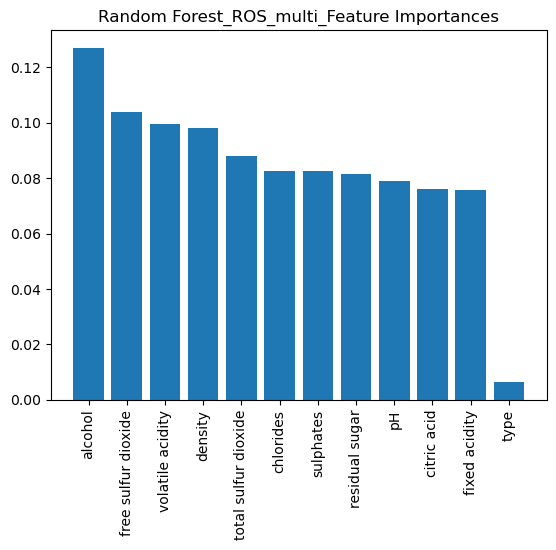

In [32]:
# feature importance 계산
importances = model_rnf_multi_ros.feature_importances_
indices = np.argsort(importances)[::-1]  # 내림차순으로 정렬된 인덱스
features = X_train_ros.columns

# 결과 출력
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

# 막대 그래프로 시각화
plt.bar(range(X_train_ros.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.title("Random Forest_ROS_multi_Feature Importances")
plt.show()


## 3) undersampling

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 랜덤 포레스트 모델 객체 생성
model_rnf_multi_rus = RandomForestClassifier()

# 탐색할 하이퍼파라미터 후보군 설정
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 2, 4, 8],
    'random_state': [100],
}

# GridSearchCV를 사용하여 최적 하이퍼파라미터 탐색
grid_search = GridSearchCV(model_rnf_multi_rus, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(X_train_rus, y_train_rus)

# 최적의 하이퍼파라미터와 성능 출력
print("Best Parameter: ", grid_search.best_params_)

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

Best Parameter:  {'max_depth': 10, 'min_samples_leaf': 2, 'n_estimators': 300, 'random_state': 100}


In [34]:
#하이퍼 파라미터 설정
model_rnf_multi_rus.set_params(max_depth=grid_search.best_params_['max_depth'], 
                     min_samples_leaf=grid_search.best_params_['min_samples_leaf'],
                     n_estimators=grid_search.best_params_['n_estimators'],
                     random_state=grid_search.best_params_['random_state'])

#모델 학습
model_rnf_multi_rus.fit(X_train_rus, y_train_rus)

#모델 예측
model_rnf_multi_rus_pred = model_rnf_multi_rus.predict(X_val)

model_rnf_multi_rus_pred

/var/folders/mw/kk0c69nj73q7k0rqrknx81_40000gn/T/ipykernel_8805/494052119.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rnf_multi_rus.fit(X_train_rus, y_train_rus)


array([5., 6., 5., ..., 5., 6., 5.])

In [35]:
eval_model_multi(y_val, model_rnf_multi_rus_pred)

[[ 27  13   8   1   0]
 [117 194  54  22  12]
 [ 68 161 145 111  79]
 [  4  17  42  90  75]
 [  2   0   5  12  25]]
0.37461059190031154
Class 4.0
4.0 class Accuracy:  nan
4.0 class Precision:  0.12385321100917432
4.0 class Recall:  0.5510204081632653
4.0 class f1:  0.20224719101123595
Class 5.0
5.0 class Accuracy:  nan
5.0 class Precision:  0.5038961038961038
5.0 class Recall:  0.48621553884711777
5.0 class f1:  0.4948979591836734
Class 6.0
6.0 class Accuracy:  nan
6.0 class Precision:  0.5708661417322834
6.0 class Recall:  0.2570921985815603
6.0 class f1:  0.3545232273838631
Class 7.0
7.0 class Accuracy:  nan
7.0 class Precision:  0.3813559322033898
7.0 class Recall:  0.39473684210526316
7.0 class f1:  0.3879310344827586
Class 8.0
8.0 class Accuracy:  nan
8.0 class Precision:  0.13089005235602094
8.0 class Recall:  0.5681818181818182
8.0 class f1:  0.21276595744680854
Macro-Average Accuracy: nan
Weighted-Average Accuracy: nan


/Users/admin/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/admin/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/admin/opt/anaconda

1. feature alcohol (0.147561)
2. feature free sulfur dioxide (0.104202)
3. feature density (0.101635)
4. feature volatile acidity (0.094017)
5. feature chlorides (0.083650)
6. feature citric acid (0.080672)
7. feature total sulfur dioxide (0.080328)
8. feature pH (0.079214)
9. feature residual sugar (0.078493)
10. feature sulphates (0.076579)
11. feature fixed acidity (0.067217)
12. feature type (0.006432)


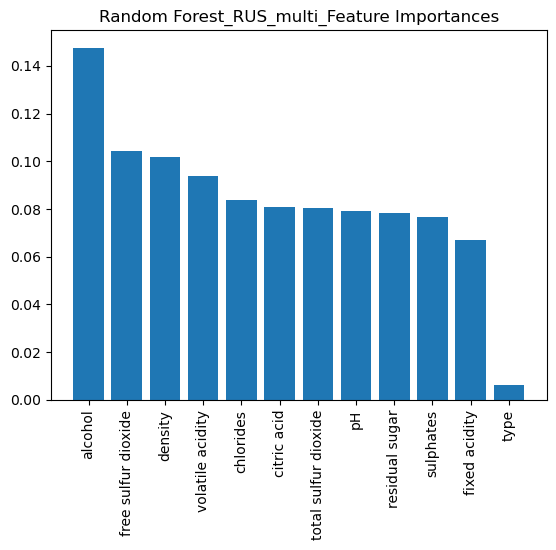

In [36]:
# feature importance 계산
importances = model_rnf_multi_rus.feature_importances_
indices = np.argsort(importances)[::-1]  # 내림차순으로 정렬된 인덱스
features = X_train_rus.columns

# 결과 출력
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, features[indices[f]], importances[indices[f]]))

# 막대 그래프로 시각화
plt.bar(range(X_train_rus.shape[1]), importances[indices])
plt.xticks(range(X.shape[1]), features[indices], rotation=90)
plt.title("Random Forest_RUS_multi_Feature Importances")
plt.show()
